# **Using DCGANs to generate face images**

### **`Deep Convolutional Generative Adversarial Networks (DCGANs)`**

In the previous section, we learned about generating images using GANs. However,
we have already seen that Convolutional Neural Networks (CNNs) perform better in
the context of images when compared to vanilla neural networks. In this section, we
will learn about generating images using Deep Convolutional Generative
Adversarial Networks (DCGANs), which use convolution and pooling operations in
the model.

First, let's understand the technique we will leverage to generate an image using a set
of 100 random numbers. We will first convert noise into a shape of batch size x 100 x 1
x 1. The reason for appending additional channel information in DCGANs and not
doing it in the GAN section is that we will leverage CNNs in this section, which
requires inputs in the form of batch size x channels x height x width.

Image Segmentation, ConvTranspose2d does the
opposite of a convolution operation, which is to take input with a smaller feature map
size (height x width) and upsample it to that of a larger size using a predefined kernel
size, stride, and padding. This way, we would gradually convert a vector from a
shape of batch size x 100 x 1 x 1 into a shape of batch size x 3 x 64 x 64. With this, we
have taken a random noise vector of size 100 and converted it into an image of a face.

In [16]:
# !wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
# !unzip -q male_female_face_images.zip

In [17]:
!pip install -q --upgrade torch_snippets
!pip install -q jsonlines
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [20]:
face_cascade.empty()

False

In [21]:
!mkdir cropped_faces

In [22]:
# Reading all the images inside the males and females folder
images = Glob('./females/*.jpg') + Glob('./males/*.jpg')

In [23]:
len(images)

28636

In [25]:
# for i in range(len(images)):
#     img = read(images[i], 1)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#     for x,y,w,h in faces:
#         img2 = img[y:(y+h), x:(x+w),:]
#     cv2.imwrite('cropped_faces/' + str(i) + '.jpg', cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
# #     break

In [26]:
# TODO: Specify the transformation to perform on each image:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [27]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [28]:
# TODO: Create the dataset object ds
ds = Faces(folder='cropped_faces')

In [29]:
# TODO: DataLoader class as follows
data_loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

In [30]:
# TODO: Define weight initialization so that the weights have a smaller spread
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [31]:
# TODO: Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(3, 64, 4, 2, 1, bias=True),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(128, 256, 4, 2, 1, bias=True),
                                   nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.BatchNorm2d(512),
                                   nn.Conv2d(512, 1, 4, 1, 0, bias=False),
                                   nn.Sigmoid())
        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)

In [32]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,136
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,544
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─LeakyReLU: 2-10                   [-1, 512, 4, 4]           --
|    └─BatchNorm2d: 2-11                 [-1, 512, 4, 4]    

In [33]:
# TODO: Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
                                   nn.Tanh())

        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)


In [34]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [35]:
# TODO: Define the discriminator and generator train step function
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real_data = discriminator(real_data)
    loss_real_data = loss(prediction_real_data.squeeze(), torch.ones(len(real_data)).to(device))
    loss_real_data.backward()

    prediction_fake_data = discriminator(fake_data)
    loss_fake_data = loss(prediction_fake_data.squeeze(), torch.zeros(len(fake_data)).to(device))
    loss_fake_data.backward()

    # Update weights
    d_optimizer.step()

    return loss_real_data + loss_fake_data


In [36]:
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()

    # Update weights
    g_optimizer.step()

    return error

In the preceding code, we are performing a `.squeeze` operation on top of
the prediction as the output of the model has a shape of **`batch size x 1 x 1 x 1`**
and it needs to be compared to a tensor that has a shape of **batch size x 1.**

In [38]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
n_epochs = 35 
log = Report(n_epochs)

In [45]:
for i in data_loader:
    print("This is the shape {}".format(i.shape))
    break

This is the shape torch.Size([64, 3, 64, 64])


EPOCH: 1.000	d_loss: 0.000	g_loss: 41.346	(917.19s - 31184.37s remaining)/rrrr
EPOCH: 2.000	d_loss: 1.420	g_loss: 20.212	(997.06s - 16451.50s remaining)rrr
EPOCH: 3.000	d_loss: 0.981	g_loss: 3.535	(1076.81s - 11485.93s remaining)/r
EPOCH: 4.000	d_loss: 0.837	g_loss: 3.315	(1156.46s - 8962.57s remaining)/rr
EPOCH: 5.000	d_loss: 0.763	g_loss: 2.969	(1236.13s - 7416.77s remaining)/r
EPOCH: 6.000	d_loss: 0.726	g_loss: 2.912	(1315.73s - 6359.35s remaining)/r
EPOCH: 7.000	d_loss: 0.697	g_loss: 2.884	(1395.38s - 5581.53s remaining)/r
EPOCH: 8.000	d_loss: 0.678	g_loss: 2.871	(1475.06s - 4978.32s remaining)/r
EPOCH: 9.000	d_loss: 0.665	g_loss: 2.830	(1554.82s - 4491.71s remaining)/r
EPOCH: 10.000	d_loss: 0.629	g_loss: 2.879	(1634.64s - 4086.59s remaining)/r
EPOCH: 11.000	d_loss: 0.597	g_loss: 2.903	(1714.37s - 3740.44s remaining)/r
EPOCH: 12.000	d_loss: 0.514	g_loss: 3.002	(1794.03s - 3438.55s remaining)/r
EPOCH: 13.000	d_loss: 0.541	g_loss: 3.128	(1873.69s - 3170.86s remaining)/r
EPOCH: 14.000

100%|██████████| 136/136 [00:01<00:00, 133.28it/s]


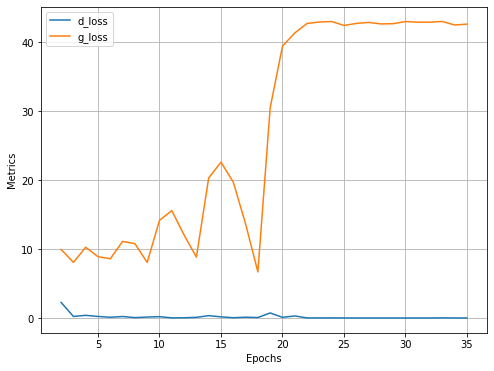

In [49]:
for epoch in range(n_epochs):
    N = len(data_loader)
    for i, images in enumerate(data_loader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        
        # Use discriminator train step to generate loss 
        d_loss = discriminator_train_step(real_data, fake_data)
        
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss = d_loss.item(), g_loss = g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

Note that the major difference between vanilla GANs and DCGANs
when generating real_data is that we did not have to flatten
real_data in the case of DCGANs as we are leveraging CNNs

Note that in this setting, the variation in generator and discriminator losses does not
follow the pattern that we have seen in the case of handwritten digit generation on
account of the following:

### **Obervation**
> We are dealing with bigger images (images that are 64 x 64 x 3 in shape
when compared to images of 28 x 28 x 1 shape.(MNIST digit)

> Digits have fewer variations when compared to the features that are
present in the image of a face.

> Information in handwritten digits is available in only a minority of pixels
when compared to the information in images of a face.

**_Generate a Sample of Images_**

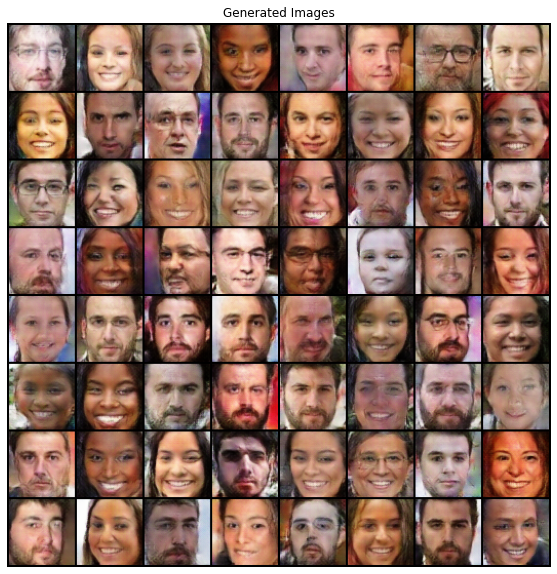

In [56]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device = device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated Images')

For improvement, DCGAN only on those images where there is no tilted face and the person is looking
straight into the camera in the original image. In addition, we suggest you try and
contrast the generated images with high discriminator scores to the ones with low
discriminator scores.

In [58]:
!mkdir checkpoint

In [59]:
def save_checkpoint(discriminator, generator, d_optimizer, g_optimizer, epoch, save_path):
    torch.save({'discirminator_state_dict': discriminator.state_dict(),
                'generator_state_dict': generator.state_dict(),
                'd_optimizer': d_optimizer.state_dict(),
                'g_optimizer': g_optimizer.state_dict(),
                'epoch': epoch
                }, save_path)

In [60]:
def load_checkpoint(discriminator, generator, d_optimizer, g_optimizer, load_path):
    checkpoint = torch.load(load_path)
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator.load_state_dict(checkpoint['generator_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer'])
    epoch = checkpoint['epoch']
    
    return discriminator, generator, d_optimizer, g_optimizer

In [65]:
save_path = 'checkpoint/DCGAN_chkpoint.pth'

In [66]:
save_checkpoint(discriminator, generator, d_optimizer, g_optimizer, epoch, save_path)

In [67]:
load_checkpoint(discriminator, generator, d_optimizer, g_optimizer, save_path)

(Discriminator(
   (model): Sequential(
     (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.2, inplace=True)
     (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=0.2, inplace=True)
     (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): LeakyReLU(negative_slope=0.2, inplace=True)
     (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (9): LeakyReLU(negative_slope=0.2, inplace=True)
     (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (12): Sigmoid()
   )
 ),
 Generator(
   (model): Sequential(

In [68]:
for epoch in range(n_epochs):
    N = len(data_loader)
    for i, images in enumerate(data_loader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        
        # Use discriminator train step to generate loss 
        d_loss = discriminator_train_step(real_data, fake_data)
        
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss = d_loss.item(), g_loss = g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

EPOCH: 1.000	d_loss: 0.097	g_loss: 22.926	(4815.19s - 163716.43s remaining)rrr
EPOCH: 2.000	d_loss: 0.853	g_loss: 12.387	(4895.13s - 80769.69s remaining)rrr
EPOCH: 3.000	d_loss: 0.617	g_loss: 4.005	(4974.96s - 53066.26s remaining)/rr
EPOCH: 4.000	d_loss: 0.512	g_loss: 3.864	(5054.73s - 39174.14s remaining)/rr
EPOCH: 5.000	d_loss: 0.504	g_loss: 3.710	(5134.60s - 30807.58s remaining)/rr
EPOCH: 6.000	d_loss: 0.453	g_loss: 3.768	(5214.46s - 25203.21s remaining)/rr
EPOCH: 7.000	d_loss: 0.452	g_loss: 3.805	(5294.29s - 21177.17s remaining)/rr
EPOCH: 8.000	d_loss: 0.476	g_loss: 3.617	(5374.20s - 18137.94s remaining)/rr
EPOCH: 9.000	d_loss: 0.411	g_loss: 3.658	(5454.08s - 15756.23s remaining)/rr
EPOCH: 9.429	d_loss: 0.062	g_loss: 3.661	(5488.64s - 14885.85s remaining)/r

KeyboardInterrupt: 

100%|██████████| 136/136 [00:00<00:00, 138.00it/s]


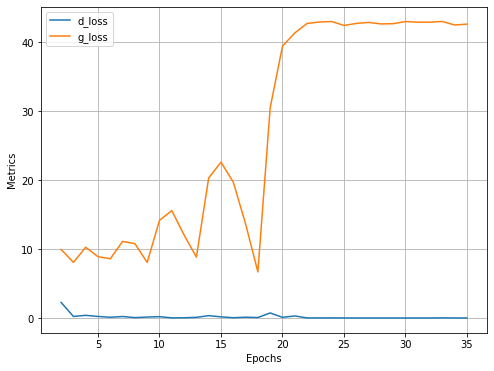

In [70]:
log.plot_epochs(['d_loss','g_loss'])

As an exercise, we suggest you train the
DCGAN only on those images where there is no tilted face and the person is looking
straight into the camera in the original image. In addition, we suggest you try and
contrast the generated images with high discriminator scores to the ones with low
discriminator scores